# 2. Data cleaning

In [86]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statistics import mode
from keras.utils import to_categorical
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Dropout
from tensorflow.python.keras.initializers import he_normal, glorot_normal
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l1,l2

## 2.1 Preliminary steps

### 2.1.1 Uploading the dataset and removing the duplicates.

In [74]:
data=pd.read_csv('BankMarketing.csv',sep=';')
data.head()

,ID,age,job,marital,education,default,housing,loan,contact,month,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,34579,35,admin.,single,university.degree,no,yes,no,cellular,may,...,1,999,1,failure,-1.8,92.893,-46.2,1.266,5099.1,no
1,446,42,technician,married,professional.course,no,no,no,telephone,may,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,yes
2,20173,36,admin.,married,university.degree,no,no,no,cellular,aug,...,2,999,0,nonexistent,1.4,93.444,-36.1,4.965,5228.1,yes
3,18171,37,admin.,married,high.school,no,yes,yes,telephone,jul,...,2,999,0,nonexistent,1.4,93.918,-42.7,4.963,5228.1,yes
4,30128,31,management,single,university.degree,no,yes,no,cellular,apr,...,1,999,0,nonexistent,-1.8,93.075,-47.1,1.365,5099.1,no


In [75]:
data.drop_duplicates(inplace=True)
data.set_index('ID',inplace=True)
print('New shape of the dataset:',*data.shape)
data.head()

New shape of the dataset: 8980 20


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
ID,,,,,,,,,,,,,,,,,,,,
34579,35,admin.,single,university.degree,no,yes,no,cellular,may,thu,1,999,1,failure,-1.8,92.893,-46.2,1.266,5099.1,no
446,42,technician,married,professional.course,no,no,no,telephone,may,tue,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,yes
20173,36,admin.,married,university.degree,no,no,no,cellular,aug,mon,2,999,0,nonexistent,1.4,93.444,-36.1,4.965,5228.1,yes
18171,37,admin.,married,high.school,no,yes,yes,telephone,jul,wed,2,999,0,nonexistent,1.4,93.918,-42.7,4.963,5228.1,yes
30128,31,management,single,university.degree,no,yes,no,cellular,apr,thu,1,999,0,nonexistent,-1.8,93.075,-47.1,1.365,5099.1,no


### 2.1.2 Checking the correct reading of the variables

In [61]:
data.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

Categorical variables are read as `object` instead of `category`.

In [76]:
cat=list(dict(data.dtypes[data.dtypes=='object']).keys())

for i in cat: 
    data[i]=data[i].astype('category')

data.dtypes

age                  int64
job               category
marital           category
education         category
default           category
housing           category
loan              category
contact           category
month             category
day_of_week       category
campaign             int64
pdays                int64
previous             int64
poutcome          category
emp.var.rate       float64
cons.price.idx     float64
cons.conf.idx      float64
euribor3m          float64
nr.employed        float64
y                 category
dtype: object

## 2.2 Reparameterizing `pdays`

In [77]:
data['pdays'].describe()

count    8980.000000
mean      885.204232
std       316.342109
min         0.000000
25%       999.000000
50%       999.000000
75%       999.000000
max       999.000000
Name: pdays, dtype: float64

`pdays` is currently being read as a continuous variable. Unfortunately there is the persistence of a value that is out of scale with respect to the others: `999`. We suppose that this value stands for a number of days that goes beyond the third year. For this reason, we suppose that people having this value have not been contacted recently. 

We have decided to reparametrize the variable into a categorical one with 4 levels: 
- `1_w`: people that have been contacted "within a week"
- `2_w`: people that have been contacted "within two weeks"
- `within_month`: people that have been contacted "within the month"
- `not_rec_cont`: which stands for people that have not been recently contacted

In [78]:
l=list(data['pdays'])

pdays_new=list()
for i in l:
    if i >=0 and i<=7:
        pdays_new.append('1_w')
    elif i>=8 and i<=14:
        pdays_new.append('2_w')
    elif i>=15 and i<=31:
        pdays_new.append('within_month')
    elif i==999:
        pdays_new.append('not_rec_cont')
        
data['pdays_new']=pdays_new
data['pdays_new']=data['pdays_new'].astype('category')
data.drop('pdays',axis=1,inplace=True)

print(data['pdays_new'].value_counts())
print(data['pdays_new'].dtypes)

not_rec_cont    7951
1_w              821
2_w              168
within_month      40
Name: pdays_new, dtype: int64
category


          index  Perc.%
0  not_rec_cont   88.54
1           1_w    9.14
2           2_w    1.87
3  within_month    0.45


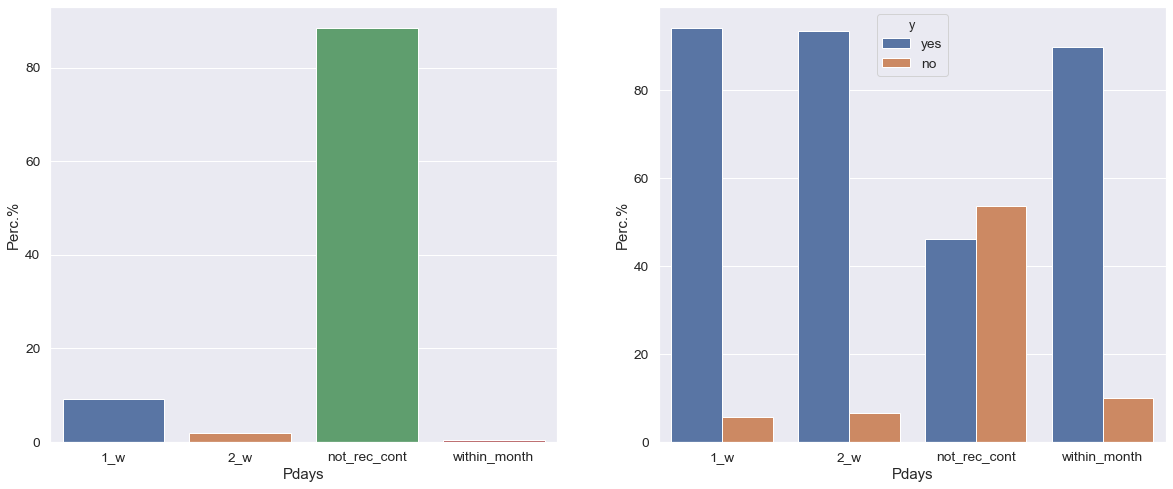

In [79]:
sns.set_style('whitegrid')
sns.set(font_scale = 1.25)

pd = (data['pdays_new'].value_counts(normalize=True)
                     .rename('Perc.%')
                     .mul(100)
                     .reset_index())
print(round(pd,2))

fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (20,8))

a=sns.barplot(x='index',y='Perc.%',data=pd,ax=ax1)
a.set(xlabel='Pdays')


pd_y = (data.groupby(['pdays_new'])['y']
         .value_counts(normalize=True)
         .rename('Perc.%')
         .mul(100)
         .reset_index())

sns.barplot(x="pdays_new", y="Perc.%", hue="y", data=pd_y,ax=ax2)
plt.xlabel('Pdays')

plt.show()

## 2.3 `unknown` imputation

During the descriptive analysis, we noticed the anomalous presence of `unknown` values in multiple variables. We suspect that these values are missing, so we decided to find ways to compute (impute) these missing values.

### 2.3.1 Checking the allocation of all the `unknown` attributes

The first thing we wanted to do is to check is the quantity of `unknown` values that are present in each variable.

In [80]:
unk_counter=dict()

for i in data.columns:
    unk_counter[i]=sum(data.loc[:,i]=='unknown')

print('In absolute terms:')
unk_counter

In absolute terms:


{'age': 0,
 'job': 75,
 'marital': 21,
 'education': 425,
 'default': 1443,
 'housing': 209,
 'loan': 209,
 'contact': 0,
 'month': 0,
 'day_of_week': 0,
 'campaign': 0,
 'previous': 0,
 'poutcome': 0,
 'emp.var.rate': 0,
 'cons.price.idx': 0,
 'cons.conf.idx': 0,
 'euribor3m': 0,
 'nr.employed': 0,
 'y': 0,
 'pdays_new': 0}

In [81]:
unk_freq=dict()

for i in data.columns:
    unk_freq[i]=round(sum(data.loc[:,i]=='unknown')/len(data),4)
    
print('In frequency terms:')
unk_freq

In frequency terms:


{'age': 0.0,
 'job': 0.0084,
 'marital': 0.0023,
 'education': 0.0473,
 'default': 0.1607,
 'housing': 0.0233,
 'loan': 0.0233,
 'contact': 0.0,
 'month': 0.0,
 'day_of_week': 0.0,
 'campaign': 0.0,
 'previous': 0.0,
 'poutcome': 0.0,
 'emp.var.rate': 0.0,
 'cons.price.idx': 0.0,
 'cons.conf.idx': 0.0,
 'euribor3m': 0.0,
 'nr.employed': 0.0,
 'y': 0.0,
 'pdays_new': 0.0}

It is possible to see that the all the `unknown` values are present in the client personal information part of the dataset. Especially in the `default` variable. 

### 2.3.2 Default

From the descriptive analysis it is possible to see that the only two levels of `default` are `No` and `unknown`. For this reason it is impossible to deduce if these `unknown` are considered `Yes` or `No`, and due that, we decided to drop this variable from the dataset.

In [82]:
data.drop('default',axis=1,inplace=True)

### 2.3.3 Job and marital 

The amount of missing values for these two variables is very low. For job they just correspond to the 0.84% of the total amount of the variable itself, while for marital just the 0.23%.<br>
Due this, we substitute the missing values in both of the variables with the mode.

In [83]:
for i in data[['job','marital']]:
    data[i].replace({'unknown':mode(data[i])},inplace=True)
print('Job:')
print(data['job'].value_counts())
print('')
print('Marital:')
print(data['marital'].value_counts())

Job:
admin.           2555
blue-collar      1663
technician       1430
services          756
management        633
retired           569
student           326
self-employed     306
entrepreneur      281
unemployed        235
housemaid         226
Name: job, dtype: int64

Marital:
married     5236
single      2791
divorced     953
Name: marital, dtype: int64


## 2.4 Education imputation through non-parametric approaches 

Education housing and loan are the variables with the higher amount of missing values. We will compute them with two different non-parametric approaches: Random forest and ANN. Both of them will be trained on the subset of data with the present values and compared using the crossvalidation approach on the subset. 

### 2.4.1 One hot encoding & train, test and validation splitting

Before training the algorithms, we need to encode the dataset by doing one-hot-encoding since in the dataset there are a lot of non categorical variables.<br>
Moreover we normalize the numerical variables.

In [84]:
data_origin=data.copy()

In [87]:
numi=['age','campaign','cons.conf.idx','cons.price.idx','emp.var.rate','euribor3m','nr.employed','previous']
data_origin[numi]=preprocessing.normalize(data_origin[numi])

data_edu=data_origin[data_origin.columns.difference(['loan','housing','education','y','contact'])]
    
data_one=pd.get_dummies(data_edu)

print('The columns are now the following:')
print('')
print(data_one.columns)

The columns are now the following:

Index(['age', 'campaign', 'cons.conf.idx', 'cons.price.idx', 'emp.var.rate',
       'euribor3m', 'nr.employed', 'previous', 'day_of_week_fri',
       'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue',
       'day_of_week_wed', 'job_admin.', 'job_blue-collar', 'job_entrepreneur',
       'job_housemaid', 'job_management', 'job_retired', 'job_self-employed',
       'job_services', 'job_student', 'job_technician', 'job_unemployed',
       'marital_divorced', 'marital_married', 'marital_single', 'month_apr',
       'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar',
       'month_may', 'month_nov', 'month_oct', 'month_sep', 'pdays_new_1_w',
       'pdays_new_2_w', 'pdays_new_not_rec_cont', 'pdays_new_within_month',
       'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success'],
      dtype='object')


In [89]:
data_one=data_one.merge(data[['education','contact','y']],on='ID')

data_one['y'].replace({'yes':1,'no':0},inplace=True)


data_one['contact']=data_one['contact'].astype('category')
data_one['contact']=data_one['contact'].cat.codes
data_one.dtypes

age                        float64
campaign                   float64
cons.conf.idx              float64
cons.price.idx             float64
emp.var.rate               float64
euribor3m                  float64
nr.employed                float64
previous                   float64
day_of_week_fri              uint8
day_of_week_mon              uint8
day_of_week_thu              uint8
day_of_week_tue              uint8
day_of_week_wed              uint8
job_admin.                   uint8
job_blue-collar              uint8
job_entrepreneur             uint8
job_housemaid                uint8
job_management               uint8
job_retired                  uint8
job_self-employed            uint8
job_services                 uint8
job_student                  uint8
job_technician               uint8
job_unemployed               uint8
marital_divorced             uint8
marital_married              uint8
marital_single               uint8
month_apr                    uint8
month_aug           

In [90]:
print('The shape of the dataset now is the following:')
data_one.head()

The shape of the dataset now is the following:


,age,campaign,cons.conf.idx,cons.price.idx,emp.var.rate,euribor3m,nr.employed,previous,day_of_week_fri,day_of_week_mon,...,pdays_new_1_w,pdays_new_2_w,pdays_new_not_rec_cont,pdays_new_within_month,poutcome_failure,poutcome_nonexistent,poutcome_success,education,contact,y
ID,,,,,,,,,,,,,,,,,,,,,
34579,0.006862,0.000196,-0.009058,0.018213,-0.000353,0.000248,0.999769,0.000196,0,0,...,0,0,1,0,1,0,0,university.degree,0,0
446,0.008089,0.000193,-0.007011,0.018103,0.000212,0.000935,0.999778,0.000000,0,0,...,0,0,1,0,0,1,0,professional.course,1,1
20173,0.006884,0.000382,-0.006904,0.017870,0.000268,0.000949,0.999792,0.000000,0,1,...,0,0,1,0,0,1,0,university.degree,0,1
18171,0.007076,0.000382,-0.008166,0.017960,0.000268,0.000949,0.999780,0.000000,0,0,...,0,0,1,0,0,1,0,high.school,1,1
30128,0.006078,0.000196,-0.009235,0.018249,-0.000353,0.000268,0.999772,0.000000,0,0,...,0,0,1,0,0,1,0,university.degree,0,0


Now that the whole dataset has been reparametrized, we divide the dataset into a train set (`sub_ed`) where the algorithms will be compared and a validation set (`val_ed`) where the `unknown` values are contained. On this last subset, predictions will be made and the `unknown` attributes will be substituted.

In [91]:
val_ed=data_one[data_one['education']=='unknown']
sub_ed=data_one[data_one['education']!='unknown']

print('Shape of the train set:',sub_ed.shape)
print('')
print('Shape of the validation set:',val_ed.shape)

Shape of the train set: (8555, 47)

Shape of the validation set: (425, 47)


From the subset `sub_ed` we label encode the variable `education` since now we don't have anymore the `unknown` parameters.

In [92]:
print('')
di = {'illiterate': 0, 'professional.course':5, 'high.school':4,'university.degree':6, 'basic.9y':3, 'basic.4y':1, 'basic.6y':2 }
sub_ed["education"].replace(di, inplace=True)
print(sub_ed['education'].head())



ID
34579    6
446      5
20173    6
18171    4
30128    6
Name: education, dtype: int64


C:\Users\ANDREA\Anaconda3\lib\site-packages\pandas\core\generic.py:6786: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


We now can explicit the X (the data) and the Y (the response) for helping us to make thing more easy further.  

In [93]:
X=sub_ed[sub_ed.columns.difference(['education'])]
Y=sub_ed['education']

### 2.4.2 First model: Random Forest

For the random forest we decided to perform a k=5 fold cross-validation for estimating the best criterion, the maximum depth that each tree should have, the minimum samples leaf and the max of the features. Moreover, we did this by crossvalidating for 5 different forests, each one with an increasing number of trees to be estimated.

In [23]:
for i in [50,100,150,200]:
    rf = RandomForestClassifier(random_state=33, n_estimators=i)
    params = {'criterion': ['gini', 'entropy'], 'max_depth': np.arange(2, 6), 'min_samples_leaf': np.logspace(-1, -3, 3),'max_features': ['sqrt', 0.2, 0.5]}
    cv_tuning = RandomizedSearchCV(rf, params, random_state=122223, scoring='accuracy', return_train_score=True, cv=5, n_iter=20)
    cv_tuning.fit(X,Y)
    print(i,' ',cv_tuning.best_score_,' ',cv_tuning.best_params_)

50   0.5263588544710696   {'min_samples_leaf': 0.001, 'max_features': 0.2, 'max_depth': 5, 'criterion': 'entropy'}
100   0.5241379310344828   {'min_samples_leaf': 0.001, 'max_features': 0.2, 'max_depth': 5, 'criterion': 'entropy'}
150   0.520864991233197   {'min_samples_leaf': 0.001, 'max_features': 0.2, 'max_depth': 5, 'criterion': 'entropy'}
200   0.5226183518410287   {'min_samples_leaf': 0.001, 'max_features': 0.2, 'max_depth': 5, 'criterion': 'entropy'}


As it is possible to see, the best random forest is the first one with 50 trees which has an accuracy of 52,6%. The algorithm in this form is more computationally heavy, but it allows us to see the best model for each different forest.

### 2.4.3 Second model: Artificial Neural Network

Here, we need to perform a train-test split since a crossvalidation for evaluating the best parameters is too computationally costly. Also, for this reason, we will test different configuration in order to find the one that suits better the data.

In [94]:
train_x,test_x,train_y,test_y=train_test_split(X, Y, test_size=0.2, random_state=123, stratify=Y,shuffle=True)

train_y_one=pd.get_dummies(train_y)
test_y_one=pd.get_dummies(test_y)

#### Config. 1: high batch size  and small learning rate in order to stabilize the training

In [25]:
model = Sequential()
model.add(Dense(32, input_dim=46, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(7, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history=model.fit(train_x, train_y_one, epochs=150, batch_size=500, verbose=1,validation_data=(test_x,test_y_one))

Train on 6844 samples, validate on 1711 samples
Epoch 1/150
6844/6844 [==============================] - 1s 125us/sample - loss: 1.9081 - accuracy: 0.2183 - val_loss: 1.8629 - val_accuracy: 0.2811
Epoch 2/150
6844/6844 [==============================] - 0s 14us/sample - loss: 1.8261 - accuracy: 0.3074 - val_loss: 1.7802 - val_accuracy: 0.3302
Epoch 3/150
6844/6844 [==============================] - 0s 11us/sample - loss: 1.7425 - accuracy: 0.3343 - val_loss: 1.6897 - val_accuracy: 0.3477
Epoch 4/150
6844/6844 [==============================] - 0s 11us/sample - loss: 1.6551 - accuracy: 0.3413 - val_loss: 1.6054 - val_accuracy: 0.3437
Epoch 5/150
6844/6844 [==============================] - 0s 11us/sample - loss: 1.5787 - accuracy: 0.3460 - val_loss: 1.5365 - val_accuracy: 0.3565
Epoch 6/150
6844/6844 [==============================] - ETA: 0s - loss: 1.5210 - accuracy: 0.36 - 0s 11us/sample - loss: 1.5158 - accuracy: 0.3717 - val_loss: 1.4780 - val_accuracy: 0.3805
Epoch 7/150
6844/6844

6844/6844 [==============================] - 0s 11us/sample - loss: 1.1627 - accuracy: 0.5513 - val_loss: 1.2072 - val_accuracy: 0.5377
Epoch 55/150
6844/6844 [==============================] - 0s 10us/sample - loss: 1.1651 - accuracy: 0.5484 - val_loss: 1.2046 - val_accuracy: 0.5348
Epoch 56/150
6844/6844 [==============================] - 0s 11us/sample - loss: 1.1622 - accuracy: 0.5511 - val_loss: 1.2038 - val_accuracy: 0.5354
Epoch 57/150
6844/6844 [==============================] - 0s 11us/sample - loss: 1.1609 - accuracy: 0.5492 - val_loss: 1.2044 - val_accuracy: 0.5301
Epoch 58/150
6844/6844 [==============================] - 0s 11us/sample - loss: 1.1603 - accuracy: 0.5494 - val_loss: 1.2052 - val_accuracy: 0.5348
Epoch 59/150
6844/6844 [==============================] - 0s 10us/sample - loss: 1.1591 - accuracy: 0.5495 - val_loss: 1.2044 - val_accuracy: 0.5359
Epoch 60/150
6844/6844 [==============================] - 0s 12us/sample - loss: 1.1579 - accuracy: 0.5510 - val_loss: 

Epoch 109/150
6844/6844 [==============================] - 0s 11us/sample - loss: 1.1333 - accuracy: 0.5631 - val_loss: 1.2090 - val_accuracy: 0.5336
Epoch 110/150
6844/6844 [==============================] - 0s 12us/sample - loss: 1.1328 - accuracy: 0.5633 - val_loss: 1.2081 - val_accuracy: 0.5377
Epoch 111/150
6844/6844 [==============================] - 0s 10us/sample - loss: 1.1311 - accuracy: 0.5639 - val_loss: 1.2093 - val_accuracy: 0.5354
Epoch 112/150
6844/6844 [==============================] - 0s 9us/sample - loss: 1.1301 - accuracy: 0.5644 - val_loss: 1.2089 - val_accuracy: 0.5359
Epoch 113/150
6844/6844 [==============================] - 0s 11us/sample - loss: 1.1299 - accuracy: 0.5624 - val_loss: 1.2095 - val_accuracy: 0.5389
Epoch 114/150
6844/6844 [==============================] - 0s 11us/sample - loss: 1.1296 - accuracy: 0.5640 - val_loss: 1.2102 - val_accuracy: 0.5342
Epoch 115/150
6844/6844 [==============================] - 0s 11us/sample - loss: 1.1293 - accuracy: 

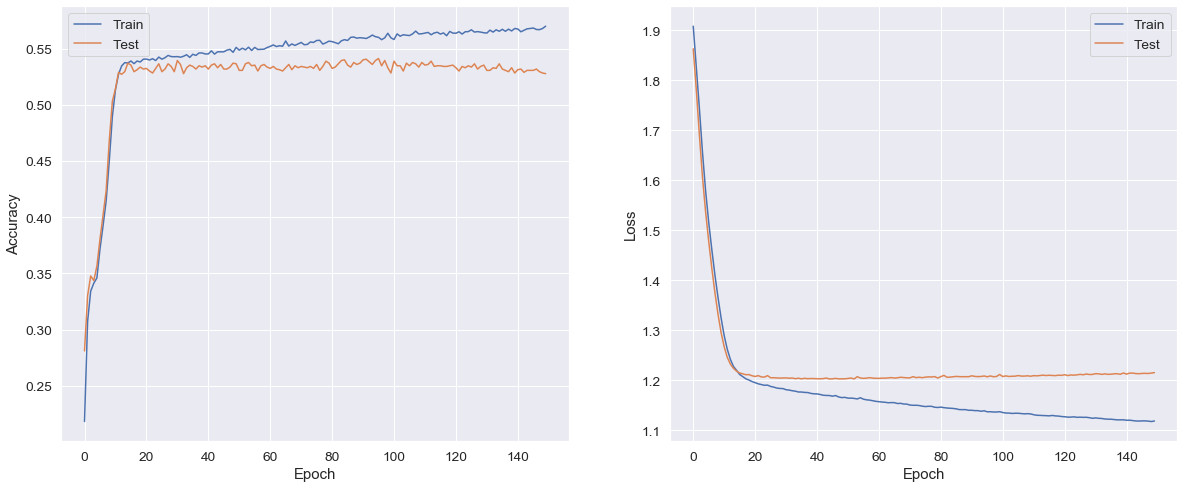

In [26]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (20,8))

ax_1=sns.lineplot(history.epoch,history.history['accuracy'],ax=ax1,label='Train')
sns.lineplot(history.epoch,history.history['val_accuracy'],ax=ax1,label='Test')
ax_1.set(xlabel='Epoch', ylabel='Accuracy')

ax_2=sns.lineplot(history.epoch,history.history['loss'],ax=ax2,label='Train')
sns.lineplot(history.epoch,history.history['val_loss'],ax=ax2,label='Test')
ax_2.set(xlabel='Epoch', ylabel='Loss')

plt.show()

#### Config. 2: reducing the batch size and learning rate in order to gain more stability but updating the weights more frequently

In [27]:
model = Sequential()
model.add(Dense(32, input_dim=46, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(7, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])

history=model.fit(train_x, train_y_one, epochs=50, batch_size=32, verbose=1,validation_data=(test_x,test_y_one))

Train on 6844 samples, validate on 1711 samples
Epoch 1/50
6844/6844 [==============================] - 2s 219us/sample - loss: 1.5471 - accuracy: 0.3824 - val_loss: 1.3182 - val_accuracy: 0.4833
Epoch 2/50
6844/6844 [==============================] - 1s 123us/sample - loss: 1.2845 - accuracy: 0.5022 - val_loss: 1.2468 - val_accuracy: 0.5278
Epoch 3/50
6844/6844 [==============================] - 1s 123us/sample - loss: 1.2372 - accuracy: 0.5291 - val_loss: 1.2279 - val_accuracy: 0.5395
Epoch 4/50
6844/6844 [==============================] - 2s 220us/sample - loss: 1.2171 - accuracy: 0.5298 - val_loss: 1.2166 - val_accuracy: 0.5319
Epoch 5/50
6844/6844 [==============================] - 1s 123us/sample - loss: 1.2052 - accuracy: 0.5323 - val_loss: 1.2079 - val_accuracy: 0.5377
Epoch 6/50
6844/6844 [==============================] - 1s 179us/sample - loss: 1.1997 - accuracy: 0.5361 - val_loss: 1.2083 - val_accuracy: 0.5324
Epoch 7/50
6844/6844 [==============================] - 2s 243us

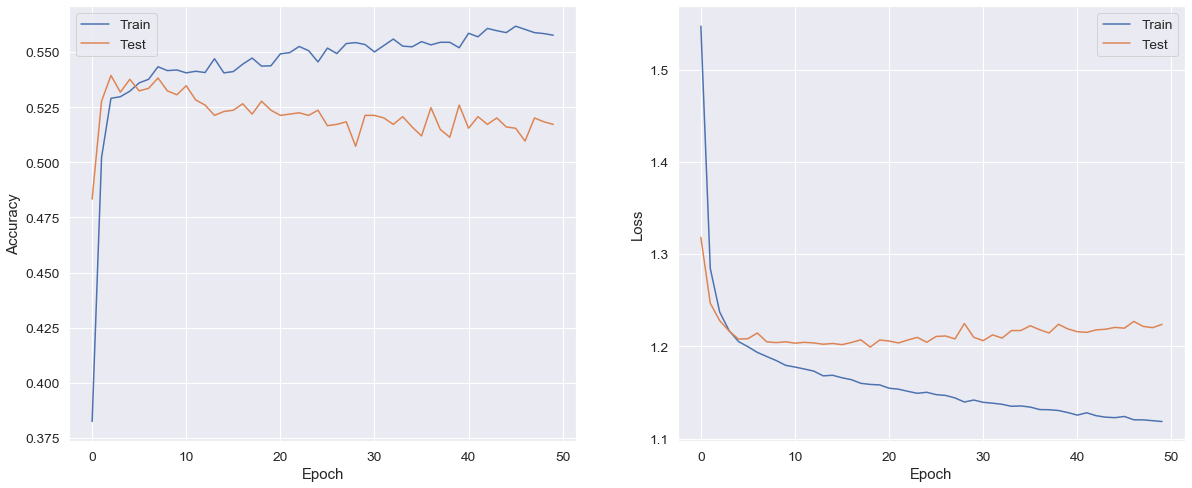

In [28]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (20,8))

ax_1=sns.lineplot(history.epoch,history.history['accuracy'],ax=ax1,label='Train')
sns.lineplot(history.epoch,history.history['val_accuracy'],ax=ax1,label='Test')
ax_1.set(xlabel='Epoch', ylabel='Accuracy')

ax_2=sns.lineplot(history.epoch,history.history['loss'],ax=ax2,label='Train')
sns.lineplot(history.epoch,history.history['val_loss'],ax=ax2,label='Test')
ax_2.set(xlabel='Epoch', ylabel='Loss')

plt.show()

#### Config 3: changing optimizer, from ADAM to SGD, and we increase the learning rate and the batch size

In [29]:
model = Sequential()
model.add(Dense(32, input_dim=46, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(7, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.1,momentum=0.5,decay=0.1/50), metrics=['accuracy'])

history=model.fit(train_x, train_y_one, epochs=50, batch_size=1000, verbose=1,validation_data=(test_x,test_y_one))

Train on 6844 samples, validate on 1711 samples
Epoch 1/50
6844/6844 [==============================] - 1s 119us/sample - loss: 1.8065 - accuracy: 0.2490 - val_loss: 1.6746 - val_accuracy: 0.3735
Epoch 2/50
6844/6844 [==============================] - 0s 9us/sample - loss: 1.6360 - accuracy: 0.3673 - val_loss: 1.5876 - val_accuracy: 0.3793
Epoch 3/50
6844/6844 [==============================] - 0s 8us/sample - loss: 1.5787 - accuracy: 0.3757 - val_loss: 1.5490 - val_accuracy: 0.3869
Epoch 4/50
6844/6844 [==============================] - 0s 6us/sample - loss: 1.5437 - accuracy: 0.3830 - val_loss: 1.5168 - val_accuracy: 0.3910
Epoch 5/50
6844/6844 [==============================] - 0s 8us/sample - loss: 1.5130 - accuracy: 0.3913 - val_loss: 1.4867 - val_accuracy: 0.3898
Epoch 6/50
6844/6844 [==============================] - 0s 7us/sample - loss: 1.4833 - accuracy: 0.3960 - val_loss: 1.4576 - val_accuracy: 0.3945
Epoch 7/50
6844/6844 [==============================] - 0s 7us/sample - lo

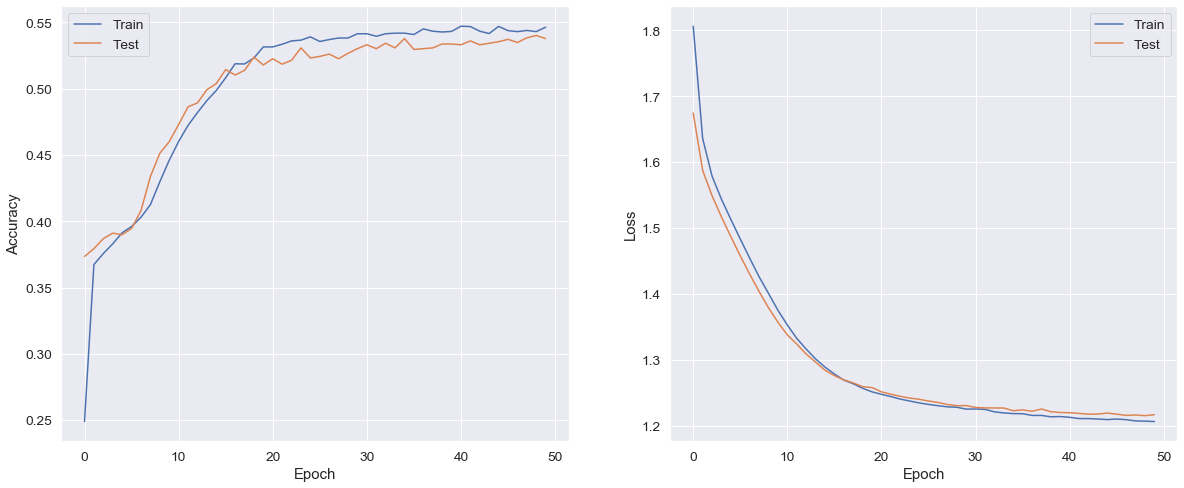

In [30]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (20,8))

ax_1=sns.lineplot(history.epoch,history.history['accuracy'],ax=ax1,label='Train')
sns.lineplot(history.epoch,history.history['val_accuracy'],ax=ax1,label='Test')
ax_1.set(xlabel='Epoch', ylabel='Accuracy')

ax_2=sns.lineplot(history.epoch,history.history['loss'],ax=ax2,label='Train')
sns.lineplot(history.epoch,history.history['val_loss'],ax=ax2,label='Test')
ax_2.set(xlabel='Epoch', ylabel='Loss')

plt.show()

The third configuration seems to be the more stable one since it is the one with less difference between the train and the test.

### 2.4.4 Conclusions and predictions

Random forest and ANN seems to have more or less the same accuracy level (around 53%), with the ANN, in the last configuration, where it seems to be a little more precise. The level of accuracy is very low, but we need to consider that the algorithms were trained on a sample of around 6800 elements and tested on around 1800 elements. So, a big chunk of information has been cut in order to provide a meter of evaluation. Surely, by using all the possible information we will be able to gain a better amount of accuracy, despite the fact that we cannot test that.<br>
We move on by generating the predictions on the last configuration of the ANN.

In [96]:
Y_dummy=pd.get_dummies(Y)

history=model.fit(X,Y_dummy, epochs=50, batch_size=1000, verbose=1)

X_imputation=val_ed[val_ed.columns.difference(['education'])]
pred=model.predict_classes(X_imputation)
val_ed['education']=list(pred)

d=val_ed.append([sub_ed])

Train on 8555 samples
Epoch 1/50
8555/8555 [==============================] - 0s 9us/sample - loss: 1.1905 - accuracy: 0.5439
Epoch 2/50
8555/8555 [==============================] - 0s 7us/sample - loss: 1.1901 - accuracy: 0.5463
Epoch 3/50
8555/8555 [==============================] - 0s 6us/sample - loss: 1.1906 - accuracy: 0.5446
Epoch 4/50
8555/8555 [==============================] - 0s 6us/sample - loss: 1.1910 - accuracy: 0.5452
Epoch 5/50
8555/8555 [==============================] - 0s 6us/sample - loss: 1.1900 - accuracy: 0.5421
Epoch 6/50
8555/8555 [==============================] - 0s 6us/sample - loss: 1.1901 - accuracy: 0.5440
Epoch 7/50
8555/8555 [==============================] - 0s 6us/sample - loss: 1.1904 - accuracy: 0.5460
Epoch 8/50
8555/8555 [==============================] - 0s 5us/sample - loss: 1.1895 - accuracy: 0.5460
Epoch 9/50
8555/8555 [==============================] - 0s 6us/sample - loss: 1.1900 - accuracy: 0.5461
Epoch 10/50
8555/8555 [===================

C:\Users\ANDREA\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


## 2.5 Housing imputation through Random Forest

We have decided to perform the imputation on the variable "Housing" with a Random Forest, since the variable has less modalities and the structure of the Random Forest has less parameters to estimated. To do that, we performed again a k=5 fold cross validation on the train side. 

In [97]:
data_house=d.merge(data_origin['housing'],on='ID')
val_ho=data_house[data_house['housing']=='unknown']
sub_ho=data_house[data_house['housing']!='unknown']

sub_ho['housing']=pd.factorize(sub_ho['housing'])[0]

X=sub_ho[sub_ho.columns.difference(['housing'])]
Y=sub_ho['housing']

C:\Users\ANDREA\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


### 2.5.1 Training

In [33]:
for i in [50,100,150,200]:
    rf = RandomForestClassifier(random_state=33, n_estimators=i)
    params = {'criterion': ['gini', 'entropy'], 'max_depth': np.arange(2, 6), 'min_samples_leaf': np.logspace(-1, -3, 3),'max_features': ['sqrt', 0.2, 0.5]}
    cv_tuning = RandomizedSearchCV(rf, params, random_state=122223, scoring='accuracy', return_train_score=True, cv=5, n_iter=20)
    cv_tuning.fit(X,Y)
    print(i,' ',cv_tuning.best_score_,' ',cv_tuning.best_params_)

50   0.5650438946528332   {'min_samples_leaf': 0.1, 'max_features': 0.5, 'max_depth': 2, 'criterion': 'gini'}
100   0.5641317979705849   {'min_samples_leaf': 0.1, 'max_features': 0.5, 'max_depth': 2, 'criterion': 'entropy'}
150   0.5639037738000228   {'min_samples_leaf': 0.1, 'max_features': 0.5, 'max_depth': 3, 'criterion': 'entropy'}
200   0.5641317979705849   {'min_samples_leaf': 0.1, 'max_features': 0.5, 'max_depth': 2, 'criterion': 'gini'}


The best model seems to be the first configuration with 50 trees. 

In [99]:
rf = RandomForestClassifier(random_state=33, n_estimators=50,
                            min_samples_leaf=0.1,
                            max_features=0.5,
                            max_depth=2,
                            criterion='gini')
rf.fit(X,Y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=2, max_features=0.5, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=0.1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=33, verbose=0,
                       warm_start=False)

### 2.5.2 Prediction

In [100]:
X_imputation=val_ho[val_ho.columns.difference(['housing'])]

predictions = rf.predict(X_imputation)

val_ho['housing']=list(predictions)

d=val_ho.append([sub_ho])

C:\Users\ANDREA\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


## 2.6 Loan imputation through Random Forest

Loan has the same structure as Housing. So, we decided to go with the same approach as for Housing.

In [101]:
data_loan=d.merge(data_origin['loan'],on='ID')

val_lo=data_loan[data_loan['loan']=='unknown']
sub_lo=data_loan[data_loan['loan']!='unknown']

sub_lo['loan']=pd.factorize(sub_lo['loan'])[0]

X=sub_lo[sub_lo.columns.difference(['loan'])]
Y=sub_lo['loan']

C:\Users\ANDREA\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### 2.6.1 Training

In [37]:
for i in [50,100,150,200]:
    rf = RandomForestClassifier(random_state=33, n_estimators=i)
    params = {'criterion': ['gini', 'entropy'], 'max_depth': np.arange(2, 6), 'min_samples_leaf': np.logspace(-1, -3, 3),'max_features': ['sqrt', 0.2, 0.5]}
    cv_tuning = RandomizedSearchCV(rf, params, random_state=122223, scoring='accuracy', return_train_score=True, cv=5, n_iter=20)
    cv_tuning.fit(X,Y)
    print(i,' ',cv_tuning.best_score_,' ',cv_tuning.best_params_)

50   0.8483639265762171   {'min_samples_leaf': 0.001, 'max_features': 'sqrt', 'max_depth': 2, 'criterion': 'gini'}
100   0.8483639265762171   {'min_samples_leaf': 0.001, 'max_features': 'sqrt', 'max_depth': 2, 'criterion': 'gini'}
150   0.8483639265762171   {'min_samples_leaf': 0.001, 'max_features': 'sqrt', 'max_depth': 2, 'criterion': 'gini'}
200   0.8483639265762171   {'min_samples_leaf': 0.001, 'max_features': 'sqrt', 'max_depth': 2, 'criterion': 'gini'}


Every random forest has the same amount of accuracy, the increase in the number of trees that are generated each time does not influence the accuracy. We will go with the easiest configuration with only 50 trees.

In [102]:
rf = RandomForestClassifier(random_state=33, n_estimators=50, min_samples_leaf=0.001,max_features='sqrt',max_depth=2,criterion='gini')
rf.fit(X,Y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=2, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=0.001, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=33, verbose=0,
                       warm_start=False)

### 2.6.2 Prediction

In [103]:
X_imputation=val_lo[val_lo.columns.difference(['loan'])]

predictions = rf.predict(X_imputation)

val_lo['loan']=list(predictions)
d=val_lo.append([sub_lo])

C:\Users\ANDREA\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


### 2.6.3 Final considerations

We think that the strange behaviour  of the accuracy in the Random Forest is justified by the amount of "No" (0s in the reparametrization).This leads to the fact that the performances of the random forests are more or less the same of an imputation through a mode. This can be proved by looking at the amount of probability that the RF assigns to the first class prediction.

In [104]:
predi=rf.predict_proba(X_imputation)
predi

array([[0.84480326, 0.15519674],
       [0.84591765, 0.15408235],
       [0.82244208, 0.17755792],
       [0.85316991, 0.14683009],
       [0.85311665, 0.14688335],
       [0.83152608, 0.16847392],
       [0.8382006 , 0.1617994 ],
       [0.84127283, 0.15872717],
       [0.80839525, 0.19160475],
       [0.83784071, 0.16215929],
       [0.85418805, 0.14581195],
       [0.84823159, 0.15176841],
       [0.84456709, 0.15543291],
       [0.82423648, 0.17576352],
       [0.84847281, 0.15152719],
       [0.84731122, 0.15268878],
       [0.8533499 , 0.1466501 ],
       [0.85204652, 0.14795348],
       [0.85209128, 0.14790872],
       [0.84991226, 0.15008774],
       [0.8408443 , 0.1591557 ],
       [0.85171831, 0.14828169],
       [0.8478479 , 0.1521521 ],
       [0.85414677, 0.14585323],
       [0.85117796, 0.14882204],
       [0.84792041, 0.15207959],
       [0.85366987, 0.14633013],
       [0.85462995, 0.14537005],
       [0.84962269, 0.15037731],
       [0.84632448, 0.15367552],
       [0.

It is possible to see that the first (0) class has always a higher probability than the second one (1). Moreover, if we look at the value counts of the dataset before and after the imputation, we can see that all the `unknown` are placed inside the 0s class (like a mode). 

In [105]:
print('Original dataset')
data.loan.value_counts()

Original dataset


no         7441
yes        1330
unknown     209
Name: loan, dtype: int64

In [106]:
print('')
d.loan.value_counts()

0    7650
1    1330
Name: loan, dtype: int64

## 2.7 Saving the new dataset

In [107]:
data=data.drop(['education','loan','housing'],axis=1)
dataset=data.merge(d[['education','loan','housing']],on='ID')
#dataset_end=dataset.to_csv(r'C:\Users\ANDREA\Desktop\Data mining\Dataset_end.csv', index = True)
dataset.head()

,age,job,marital,contact,month,day_of_week,campaign,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,pdays_new,education,loan,housing
ID,,,,,,,,,,,,,,,,,,,
34579,35,admin.,single,cellular,may,thu,1,1,failure,-1.8,92.893,-46.2,1.266,5099.1,no,not_rec_cont,6,0,1
446,42,technician,married,telephone,may,tue,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,yes,not_rec_cont,5,0,0
20173,36,admin.,married,cellular,aug,mon,2,0,nonexistent,1.4,93.444,-36.1,4.965,5228.1,yes,not_rec_cont,6,0,0
18171,37,admin.,married,telephone,jul,wed,2,0,nonexistent,1.4,93.918,-42.7,4.963,5228.1,yes,not_rec_cont,4,1,1
30128,31,management,single,cellular,apr,thu,1,0,nonexistent,-1.8,93.075,-47.1,1.365,5099.1,no,not_rec_cont,6,0,1
